In [55]:
!pip install mne

In [56]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Dropout, BatchNormalization, Input, Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from collections import Counter
import warnings
import pandas as pd

In [57]:
subject_id = 1
runs = [5, 9, 13]

fnames = mne.datasets.eegbci.load_data(subject_id, runs)

raws = [mne.io.read_raw_edf(f, preload=True) for f in fnames]
raw = mne.io.concatenate_raws(raws)

print("Data berhasil dimuat dan digabung.")

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Data berhasil dimuat dan digabung.


In [58]:
print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


In [59]:
sampling_rate = raw.info['sfreq']
n_channels = raw.info['nchan']
channel_names = raw.info['ch_names']

print(f"--- Informasi Struktur Data ---")
print(f"1. Sampling Rate: {sampling_rate} Hz")
print(f"2. Jumlah Channel: {n_channels}")
print(f"3. Daftar Nama Channel (contoh 5 pertama): {channel_names[:5]}")
print(f"4. Format Data Mentah: Data dimuat dari file .edf")
print(f"   Total Durasi Data: {raw.times.max():.2f} detik")

--- Informasi Struktur Data ---
1. Sampling Rate: 160.0 Hz
2. Jumlah Channel: 64
3. Daftar Nama Channel (contoh 5 pertama): ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.']
4. Format Data Mentah: Data dimuat dari file .edf
   Total Durasi Data: 374.99 detik


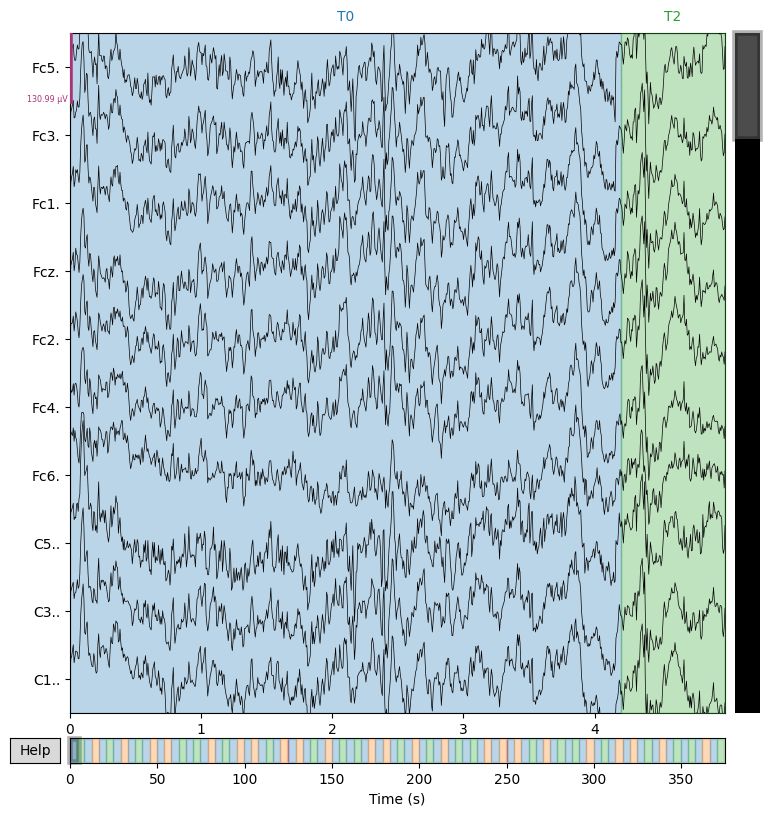

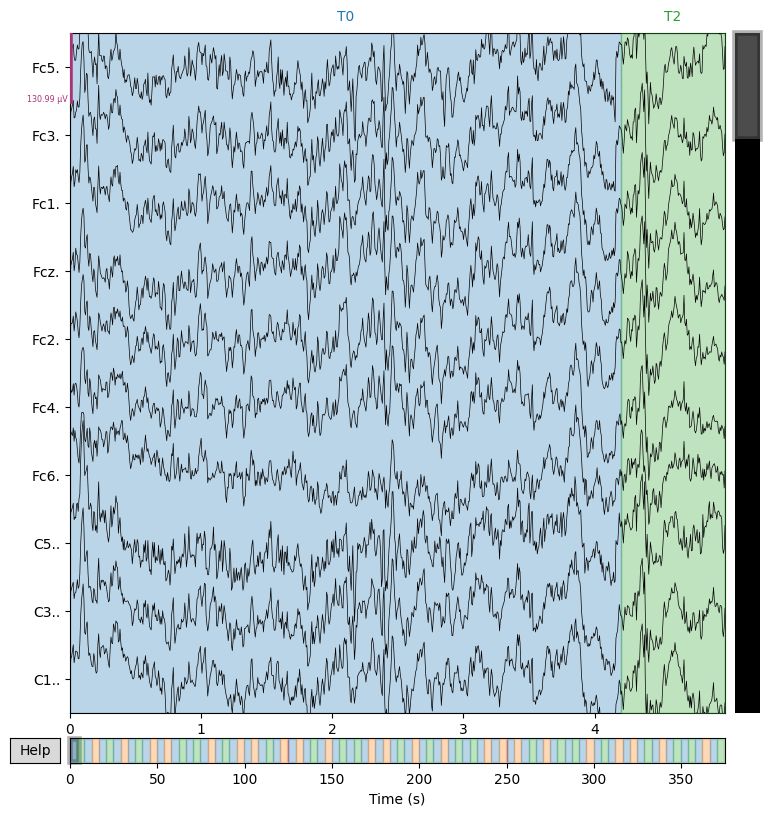

In [60]:
raw.plot(duration=5, n_channels=10, scalings='auto', title='Contoh Sinyal EEG Mentah')

In [61]:
events, event_id = mne.events_from_annotations(raw)

print("--- Informasi Label (Events) ---")
print("Event ID (Label ke Angka):")
print(event_id)

print(f"\nTotal events ditemukan: {len(events)}")
print("Bentuk array events (sample_index, 0, event_code):")
print(events[:5])

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
--- Informasi Label (Events) ---
Event ID (Label ke Angka):
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}

Total events ditemukan: 90
Bentuk array events (sample_index, 0, event_code):
[[   0    0    1]
 [ 672    0    3]
 [1328    0    1]
 [2000    0    2]
 [2656    0    1]]


In [62]:
event_codes = events[:, 2]

event_counts = Counter(event_codes)

labels_map = {v: k for k, v in event_id.items()}

print("\n--- Distribusi Label Kelas ---")
for code, count in event_counts.items():
    if code in labels_map:
        print(f"Label: {labels_map[code]} (Kode: {code}) \t-> Jumlah Trials: {count}")


--- Distribusi Label Kelas ---
Label: T0 (Kode: 1) 	-> Jumlah Trials: 45
Label: T2 (Kode: 3) 	-> Jumlah Trials: 22
Label: T1 (Kode: 2) 	-> Jumlah Trials: 23


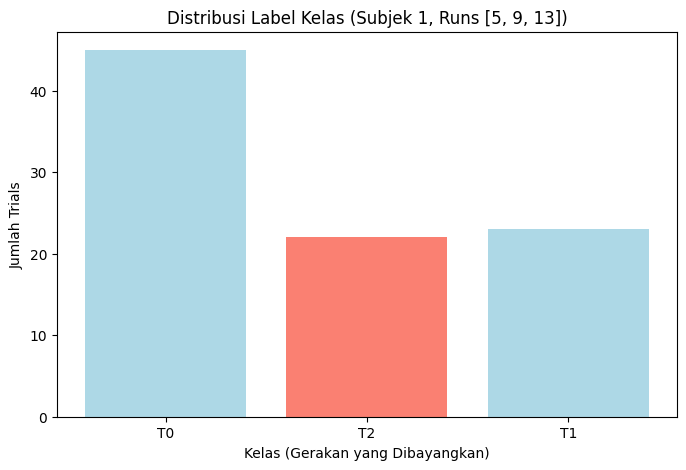

In [63]:
labels = [labels_map[code] for code, count in event_counts.items() if code in labels_map]
counts = [count for code, count in event_counts.items() if code in labels_map]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['lightblue', 'salmon'])
plt.title(f'Distribusi Label Kelas (Subjek {subject_id}, Runs {runs})')
plt.xlabel('Kelas (Gerakan yang Dibayangkan)')
plt.ylabel('Jumlah Trials')
plt.show()

In [64]:
subjects_to_check = range(1, 51)

runs = [5, 9, 13]

all_subject_data = []

print(f"Akan memulai inspeksi untuk {len(list(subjects_to_check))} subjek...")

Akan memulai inspeksi untuk 50 subjek...


In [ ]:
warnings.filterwarnings('ignore')

for sub_id in subjects_to_check:
    print(f"\nMemproses Subjek {sub_id}...")

    try:
        fnames = mne.datasets.eegbci.load_data(sub_id, runs)
        raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f) for f in fnames])

        sfreq = raw.info['sfreq']
        n_channels = raw.info['nchan']

        events, event_map = mne.events_from_annotations(raw)

        counts = Counter(events[:, 2])
        t1_count = counts.get(event_map.get('T1', 99), 0) 
        t2_count = counts.get(event_map.get('T2', 98), 0)

        all_subject_data.append({
            'Subjek': sub_id,
            'Sampling Rate': sfreq,
            'Jml Channel': n_channels,
            'Trials T1 (Tangan)': t1_count,
            'Trials T2 (Kaki)': t2_count,
            'Status': 'OK'
        })

    except Exception as e:
        print(f"GAGAL memproses Subjek {sub_id}. Error: {e}")
        all_subject_data.append({
            'Subjek': sub_id,
            'Sampling Rate': 'N/A',
            'Jml Channel': 'N/A',
            'Trials T1 (Tangan)': 'N/A',
            'Trials T2 (Kaki)': 'N/A',
            'Status': 'Error'
        })

print("\n--- Inspeksi Selesai ---")


Memproses Subjek 1...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 2...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/

In [66]:
df_results = pd.DataFrame(all_subject_data).set_index('Subjek')

print("Tabel Ringkasan EDA untuk Subjek 1-15:")
display(df_results)

Tabel Ringkasan EDA untuk Subjek 1-15:


,Sampling Rate,Jml Channel,Trials T1 (Tangan),Trials T2 (Kaki),Status
Subjek,,,,,
1,160.0,64,23,22,OK
2,160.0,64,21,24,OK
3,160.0,64,22,23,OK
4,160.0,64,22,23,OK
5,160.0,64,22,23,OK
6,160.0,64,22,23,OK
7,160.0,64,22,23,OK
8,160.0,64,22,23,OK
9,160.0,64,23,22,OK


In [67]:
print("\n--- Analisis Konsistensi Data ---")

ok_subjects = df_results[df_results['Status'] == 'OK']

if not ok_subjects.empty:
    sfreq_konsisten = ok_subjects['Sampling Rate'].nunique() == 1
    sfreq_value = ok_subjects['Sampling Rate'].iloc[0]
    print(f"1. Sampling Rate: {'KONSISTEN' if sfreq_konsisten else 'TIDAK KONSISTEN'}")
    if sfreq_konsisten:
        print(f"   -> Semua subjek memiliki {sfreq_value} Hz.")

    ch_konsisten = ok_subjects['Jml Channel'].nunique() == 1
    ch_value = ok_subjects['Jml Channel'].iloc[0]
    print(f"2. Jml Channel:   {'KONSISTEN' if ch_konsisten else 'TIDAK KONSISTEN'}")
    if ch_konsisten:
        print(f"   -> Semua subjek memiliki {ch_value} channels.")

    ok_subjects['Imbalance'] = abs(ok_subjects['Trials T1 (Tangan)'] - ok_subjects['Trials T2 (Kaki)'])
    avg_imbalance = ok_subjects['Imbalance'].mean()
    print(f"3. Keseimbangan Label:")
    print(f"   -> Rata-rata ketidakseimbangan (T1 vs T2) per subjek: {avg_imbalance:.2f} trials")
    print(f"   -> Subjek dengan imbalance > 2 trials:\n {ok_subjects[ok_subjects['Imbalance'] > 2][['Imbalance']]}")

else:
    print("Tidak ada data subjek yang berhasil diproses.")


--- Analisis Konsistensi Data ---
1. Sampling Rate: KONSISTEN
   -> Semua subjek memiliki 160.0 Hz.
2. Jml Channel:   KONSISTEN
   -> Semua subjek memiliki 64 channels.
3. Keseimbangan Label:
   -> Rata-rata ketidakseimbangan (T1 vs T2) per subjek: 1.40 trials
   -> Subjek dengan imbalance > 2 trials:
         Imbalance
Subjek           
2               3
13              3
14              3
18              3
20              3
25              3
28              3
31              3
33              3
44              3



--- Visualisasi Keseimbangan Label (T1 vs T2) per Subjek ---


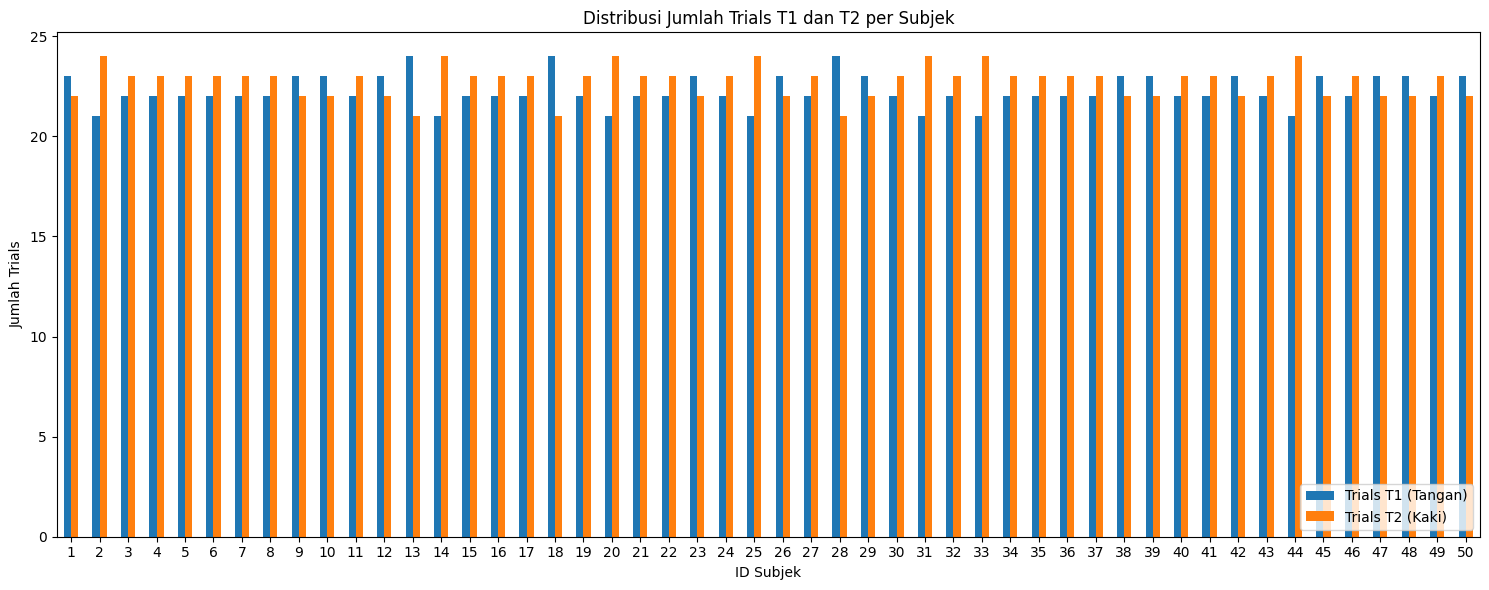

In [68]:
print("\n--- Visualisasi Keseimbangan Label (T1 vs T2) per Subjek ---")

if not ok_subjects.empty:
    ax = ok_subjects[['Trials T1 (Tangan)', 'Trials T2 (Kaki)']].plot(
        kind='bar',
        stacked=False,
        figsize=(15, 6),
        rot=0,
        title='Distribusi Jumlah Trials T1 dan T2 per Subjek'
    )
    ax.set_xlabel("ID Subjek")
    ax.set_ylabel("Jumlah Trials")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [69]:
subject_ids = range(1, 51)
runs = [5, 9, 13]

X_all = []
y_all = []

In [ ]:
print(f"Load data: {subject_ids}...")

for subject_id in subject_ids:
    try:
        fnames = mne.datasets.eegbci.load_data(subject_id, runs, verbose=False)
        raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in fnames])

        mne.datasets.eegbci.standardize(raw)

        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)

        raw.filter(1.0, 50.0, fir_design='firwin', verbose=False)
        events, event_id = mne.events_from_annotations(raw, verbose=False)

        picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

        tmin, tmax = 0.5, 6.0
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                            baseline=None, preload=True, verbose=False)

        X = epochs.get_data()
        y = epochs.events[:, -1]

        unique_y = np.unique(y)
        y = np.where(y == unique_y[0], 0, 1)

        X_all.append(X)
        y_all.append(y)

    except Exception as e:
        print(f"Error pada subjek {subject_id}: {e}")

Load data: range(1, 51)...


In [71]:
X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)

print(f"\nTotal Data Shape: {X.shape}")
print(f"Total Label Shape: {y.shape}")


Total Data Shape: (4350, 64, 881)
Total Label Shape: (4350,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
X_train_1d = np.transpose(X_train, (0, 2, 1))
X_val_1d   = np.transpose(X_val, (0, 2, 1))
X_test_1d  = np.transpose(X_test, (0, 2, 1))

In [ ]:
scaler = StandardScaler()

def scale_data(data_3d, scaler, fit=False):
    N, T, C = data_3d.shape
    data_2d = data_3d.reshape(N * T, C)
    if fit:
        scaler.fit(data_2d)
    data_scaled_2d = scaler.transform(data_2d)
    return data_scaled_2d.reshape(N, T, C)

X_train_1d = scale_data(X_train_1d, scaler, fit=True)
X_val_1d   = scale_data(X_val_1d, scaler)
X_test_1d  = scale_data(X_test_1d, scaler)

print(f"\nShape Input Network (Train): {X_train_1d.shape}")


Shape Input Network (Train): (2784, 881, 64)


In [75]:
n_timesteps = X_train_1d.shape[1]
n_features  = X_train_1d.shape[2]

model = Sequential()
model.add(Input(shape=(n_timesteps, n_features)))

model.add(Conv1D(filters=32, kernel_size=64, padding='same', activation='elu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=32, padding='same', activation='elu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.0)))
model.add(BatchNormalization())

model.add(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.0))
model.add(BatchNormalization())

model.add(Dense(32, activation='elu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 881, 32)        │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 881, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 220, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 220, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 220, 64)        │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 220, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 55, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 55, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,473 (1.09 MB)

 Trainable params: 284,961 (1.09 MB)

 Non-trainable params: 512 (2.00 KB)

In [76]:
opt = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',    
    monitor='val_accuracy',        
    save_best_only=True,           
    mode='max',                   
    verbose=1                     
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [78]:
history = model.fit(
    X_train_1d, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val_1d, y_val),
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5200 - loss: 2.0549
Epoch 1: val_accuracy improved from -inf to 0.53448, saving model to best_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5200 - loss: 2.0545 - val_accuracy: 0.5345 - val_loss: 1.7785 - learning_rate: 5.0000e-04
Epoch 2/100
85/87 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5261 - loss: 1.8814
Epoch 2: val_accuracy improved from 0.53448 to 0.53592, saving model to best_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5261 - loss: 1.8796 - val_accuracy: 0.5359 - val_loss: 1.6609 - learning_rate: 5.0000e-04
Epoch 3/100
86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5163 - loss: 1.7150
Epoch 3: val_accuracy improved from 0.53592 to 0.55316, saving model to best_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5164 - loss: 1.7139 - val_accuracy: 0.5532 - val_loss: 1.5228 - learning_rate: 5.0000e-04
Epoch 4/100
86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 30m

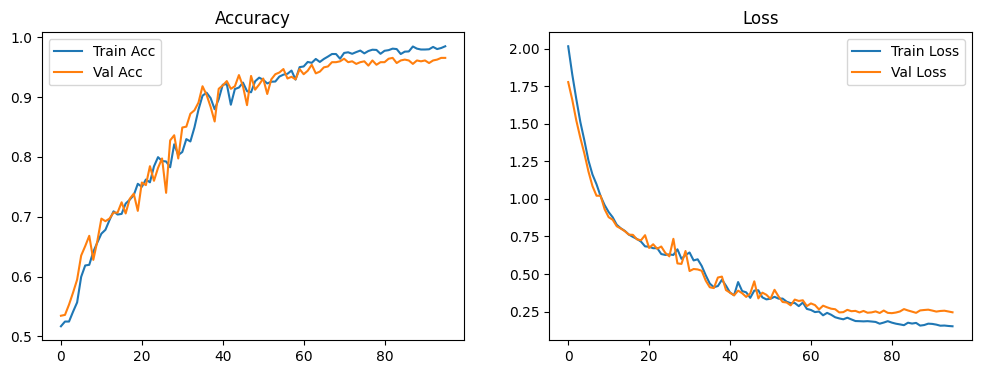

In [79]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

--- Classification Result (Test Set) ---
                 precision    recall  f1-score   support

Class 0 (Hands)       0.94      0.92      0.93       450
 Class 1 (Feet)       0.91      0.94      0.93       420

       accuracy                           0.93       870
      macro avg       0.93      0.93      0.93       870
   weighted avg       0.93      0.93      0.93       870


--- Confusion Matrix ---


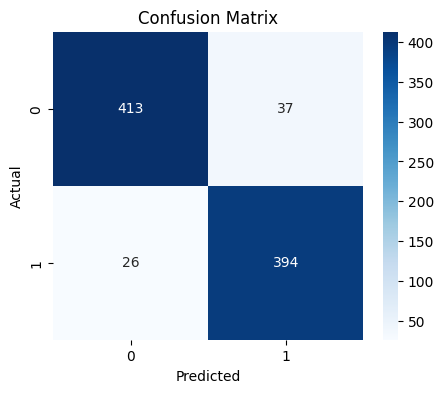

In [80]:
y_pred_proba = model.predict(X_test_1d)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n--- Classification Result (Test Set) ---")
print(classification_report(y_test, y_pred, target_names=['Class 0 (Hands)', 'Class 1 (Feet)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [81]:
saved_model = load_model('best_model.keras')

loss, accuracy = saved_model.evaluate(X_test_1d, y_test)
print(f"Akurasi Model Terbaik pada Test Set: {accuracy*100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9415 - loss: 0.3060
Akurasi Model Terbaik pada Test Set: 94.02%
